# CORPUS ANALYSIS OF POLITICAL ASSOCIATIONS UTILIZING NATURAL LANGUAGE PROCESSING
Marcus Hilliard*, Rikita Hirpara*, Doron Meizlik*, Katie Zink*
*Northwestern University, Department of Data Science, Chicago, IL


Our corpus consists of documents related to President Biden’s administration and the policies his team has decided to pursue during his presidency. The initial processing of the documents consisted of removing numbers, punctuation, words less than four letters long, and stop words. From there, we were able to get the words from all the documents into a list and perform further analysis such as calculating TF-IDF scores, Doc2Vec/Word2Vec scores, clustering, and plotting.

## Code Outline

**Question to answer**: Based on ontology and ground truth there are 6 topics, How does the choices in the preprocessing steps affect the LDA results?

*Preprocessing*
* Baseline - lower, punk, alphabet


*EDA*
* PCA document reduction


*Creating vector representations of the documents*
* TDIDF, Word2Doc, Bag-of-Words


*Clustering algorithms*
* Hiarchial clustering (unsup)
* k-means (sup)

*Topic Mapping*
* LDA - with Baseline
* LDA with different preprocessing add-ons
  * LDA visualization
  * Add remove stopwords
  * add remove stopwords, remove short words
  * add remove stopwords, remove short words, EC
  * Add remove stopwords, remove short words, EC, contractions
  * Add remove stopwords, remove short words, EC, contractions, lemmatization


ground truth:

possible topics:
  * covid fight - 0, 1, 2, 3, 6, 7, 9, 10, 51
  * trade policy - 4, 5
  * healthcare generally (non-covid) - 8, 11, 12
  * legislative wrangling - 19, 20education - 21, 22
  * immigration policy - 23, 24, 40, 41
  * tax policy - 25, 26, 27
  * climate change - 28, 29, 42, 43, 44, 45
  * student loans - 31, 35, 36
  * washington local economy - 32, 33
  * economic stimulus - 37, 38, 39, 46, 47, 52
  * agenda for women - 48, 49, 50

not sure which topic they go in:
  * first 100 days (mix) - 13, 14, 15, 16, 17, 18
  * hariet tubman (dunno) - 30
  * amtrak joe (dunno) - 34

# Data Libraries

## Data Load and Packages

In [ ]:
import math

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import re,string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from keras.preprocessing.text import Tokenizer

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import gensim
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *


from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# interactive topic modeling visualization
#import pyLDAvis
#import pyLDAvis.gensim

# spacy for lemmatization
import spacy
from spacy import displacy
import datetime
from tqdm import tqdm

from termcolor import colored
import textwrap

print("Done")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Done


## User Dictionaries

### Dictionary of English Contractions

In [ ]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

### Dictionary of Equivalence Classes

In [ ]:
ec_dict = {"biden": ['president biden', 'biden', 'the president',
                     'joe biden', 'biden administration', 
                     'harris administration', 'mr. biden',
                     'president elect', 'president-elect',
                     'joseph r. biden jr.', 'joseph r. biden',
                     'biden harris administration', 'biden-harris administration',
                     'the white house'],
          "trump": ['president trump', 'former president', 
                    'trump', 'donald trump', 
                    'trump adminstration', 'mr. trump'],
          "republican": ['republicans', 'republican', 'republican-controlled'],
           "democratic": ['democrat, democrats', 'democratic', 'democrat-controlled'],
          "loanforgiveness": ['loan forgiveness','loan forbearance', 'loan cancellation', 
                               'loan relief', 'loan assistance', 'loan help'],
          "covid": ['covid','covid-19', 'coronavirus', 'virus'],
           "vaccine": ['vaccines', 'vaccine', 'vaccination', 'vaccinated'],
           "pandemic": ['pandemic', 'global pandemic'],
          "economy": ['economy','economic'],
          "family": ['family','families'],
           "citizens": ['citizens', 'the people', 'american people'],
           "healthcare": ['healthcare', 'health care', 'medical care'],
           "climatechange": ['climate change', 'global warming']}




## User Functions

### Function for finding contractions

In [ ]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

### Function to find equivalence classes

In [ ]:
# Function to find and replace Equivalence Classes
def create_ec(text, dictionary=ec_dict):
    for key, values in dictionary.items():
        for value in values:
            text= text.replace(value, key)
    return text

### Function to tag words by tense of speech

In [ ]:
def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Function to iterate through values in dictionary

In [ ]:
# Iterating through value lists dictionary
def res_go():
  res = [] 
  for x in ec_dict.keys():
    for i in ec_dict[x]:
      res.append(i)
  return res

In [ ]:
def color_word(word):
  keyList = list(ec_dict.keys())
  colorList = ['white', 'white', 'white', 'white', 'red', 'white', 'red', 'green', 'blue', 'blue', 'magenta', 'cyan']
  oncolorList = ['on_magenta', 'on_green', 'on_blue', 'on_red',  'on_yellow', 'on_cyan', 'on_white', 'on_white', 'on_white', 'on_white', 'on_white']
  for x in ec_dict.keys():
    for i in ec_dict[x]:
      if word == i:
        for j in range(len(keyList)):
          if x == keyList[j]:
            return colored(word.upper(),color=colorList[j], on_color=oncolorList[j], attrs=['bold'])

### Function to highlight words in text output

In [ ]:
def highlight_words(sentence, words):
    for word in words:
        pos = sentence.lower().find(word.lower())
        sentence = sentence if pos < 0 else sentence[0:pos] + color_word(word) + highlight_words(sentence[pos + len(word):], [word])
    return sentence

### add new words to exclude to stopword dictionary

In [ ]:
stopwords1 = nltk.corpus.stopwords.words('english')

stopwords2 = stopwords1
newStopWords = ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 
                   'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 
                   'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 
                   'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come',
                   
                   'biden', 'trump', 'president', 'federal', 'government', 'administration', 'vice',
                    'cannot', 'obama', 'presidential', 'like', 'miss', 'year', 'much', 'kamala',
                 'harris', 'department', 'white', 'director', 'say', 'says', 'said', 'saying', 'went',
                'regardless']

stopwords2.extend(newStopWords)

stopwords = stopwords2

### Function to process text

Baseline - lower, punk, alphabet
* Add remove stopwords
* add remove stopwords, remove short words
* Add remove stopwords, remove short words, contractions
* Add remove stopwords, remove short words, contractions, lemmatization




In [ ]:
def clean_doc(doc): 


# equivalence class part

    # run through EC find-and-replace
    doc = create_ec(doc.lower())

  
# all of these are part of baseline model: 

    ## split document into individual words
    tokens=doc.split()
    ##lowercase all words
    tokens = [word.lower() for word in tokens]
    ## expand contractions the tokens
    #tokens = [expand_contractions(word) for word in tokens]
    ## remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    ## remove punctuation from each word
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]


# everything below, along with EC library above, is part of our

    ## filter out stop words from NLTK library
    tokens = [w for w in tokens if not w in stopwords]  

    ## filter out short tokens
    tokens = [word for word in tokens if len(word) >= 4]
    
    ## convert the tense of words to present tense
    tokens = [WordNetLemmatizer().lemmatize(word, get_wordnet_pos(word)) for word in tokens]

    ## word stemming
    #stemmer = PorterStemmer()
    #stemmer = SnowballStemmer("english")
    #tokens=[stemmer.stem(word) for word in tokens]

    return tokens



## Import Corpus

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

work_dir = "/content/gdrive/My Drive/MSDS_453_zis78e3or6/"

data = pd.read_csv(work_dir +'2021_Winter_453_Sec55_Class_Corpus 03.03.21.csv')

Mounted at /content/gdrive


In [ ]:
data.head()

,File Name,Title,Authors,Source,Date,URL,Word Count,Text
0,Biden-NationalCovidStrategy-Doc1.docx,"Biden releases national COVID strategy, will order agencies to use Defense Production Act",Jessie Hellmann,Thehill.com,1/21/2021,https://thehill.com/policy/healthcare/535157-biden-to-order-agencies-to-use- defense-production...,545,"President Biden released his national strategy to end the COVID-19 pandemic Thursday, which will..."
1,Biden_Covid_Strategy (1).txt,Biden pledges to boost COVID-19 vaccine effort to meet goal of 100 million shots in 100 days: ‘W...,RICARDO ALONSO-ZALDIVAR and BILL BARROW,Associated Press,1/15/2021,https://www.chicagotribune.com/coronavirus/ct-nw-biden-covid-vaccine-plan-20210116-mjoapycwjnhr3...,1030,President-elect Joe Biden pledged Friday to boost supplies of coronavirus vaccine and set up new...
2,Biden_Covid_Strategy (2).txt,Biden unveils $1.9T plan to stem COVID-19 and steady economy,RICARDO ALONSO-ZALDIVAR and BILL BARROW,Associated Press,1/14/2021,https://apnews.com/article/joe-biden-coronavirus-action-plan-3d8d5841bb9098a81ad9452fb2619024,1089,President-elect Joe Biden unveiled a $1.9 trillion coronavirus plan Thursday to end “a crisis of...
3,Biden-NationalCovidStrategy-Doc2.txt,Biden unveils national COVID strategy with slate of executive orders,"Arden Farhi, Audrey Mcnamara",CBS News,1/21/2021,https://www.cbsnews.com/news/biden-national-covid-strategy-executive-orders/,586,Experts expect the United States' COVID-19 death toll to reach half a million people next month....
4,CB_Biden Signs Buy American Order for Government Procurement.txt,Biden Signs Buy American Order for Government Procurement \nOrder revises definition of U.S.-mad...,Yuka Hayashi,Wall Street Journal,1/25/2021,https://www.wsj.com/articles/biden-to-sign-buy-american-order-for-government-procurement-1161156...,808,President Biden signed an executive order Monday imposing tougher rules on government procuremen...


# Preprocessing

In [ ]:
#Create list to store text document file names
titles=data['File Name']

# Create a list of the document number
doc_num=[]
for i in range(0,len(data)):
    doc_num.append(i)

# Create list to store text documents
text_body=data['Text']

print('Done')

Done


### Cleaning text

The text is processes in several ways whereby each sentence is broken up into individual words called tokens. Then each token is processed in the following process flow:
* converted to lowercase characters
* word contractions are expanded
* the part of speech for each token is then converted to present tense
* punctuation is removed
* non-alphabetic characters are removed
* words than are less than 2 characters are removed
* stop words are removed 

In [ ]:
processed_text=[]

for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

stitch_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    stitch_processed_text.append(temp_DSI)

final_processed_text=[]
for i in range(len(stitch_processed_text)):
  tmp_text = stitch_processed_text[i]
  final_processed_text.append(tmp_text)

print("Done")

Done


# EDA

## Corpus EDA

* Bring over TDIDF and Word2Vec visuals


### Articles by word count

Let's look the articles by word count

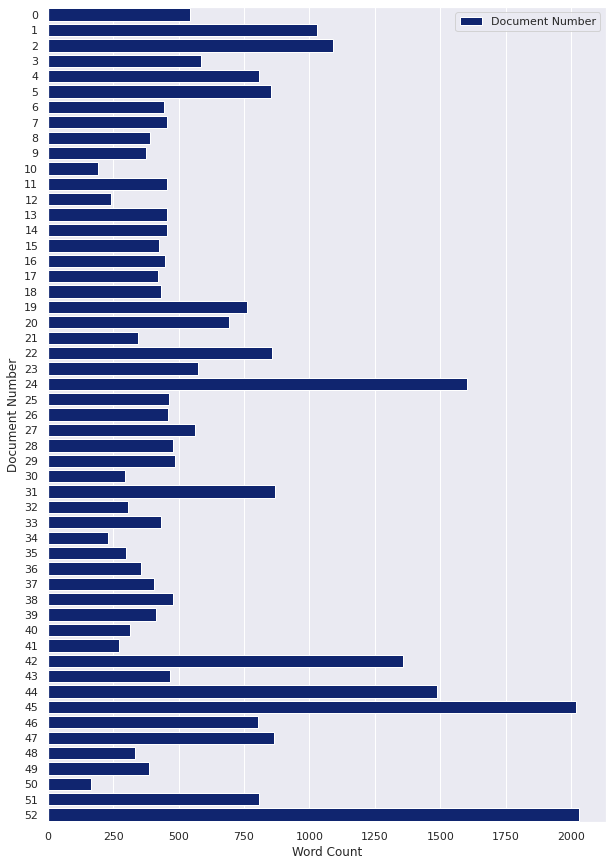

In [ ]:
eda_df = data.copy()
eda_df = eda_df.sort_values(by=['Date'], ascending=False)

f, ax = plt.subplots(figsize = (10,15))
sns.set_color_codes('dark')
sns.barplot(y=eda_df.index, x="Word Count", data=eda_df, 
            label = "Document Number", color = 'b', edgecolor = 'w',
            orient='h')
ax.set_xlabel('Word Count')
ax.set_ylabel('Document Number')
ax.legend(ncol = 1)
#sns.despine(left = True, bottom = True)
plt.show()

### Documents mean and median

In [ ]:
print("mean:", round(data['Word Count'].mean(), 1))
print("median:", round(data['Word Count'].median(), 1))

mean: 618.6
median: 457.0


### Articles by Source

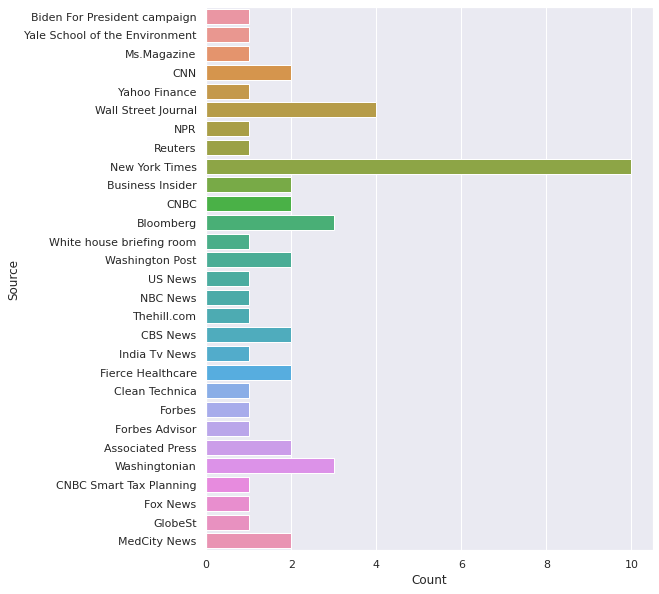

In [ ]:
f, ax = plt.subplots(figsize = (8,10))
sns.set_color_codes('dark')
sns.countplot(y='Source', data=eda_df, orient='h')
ax.set_xlabel('Count')
plt.show()

### Articles by Date

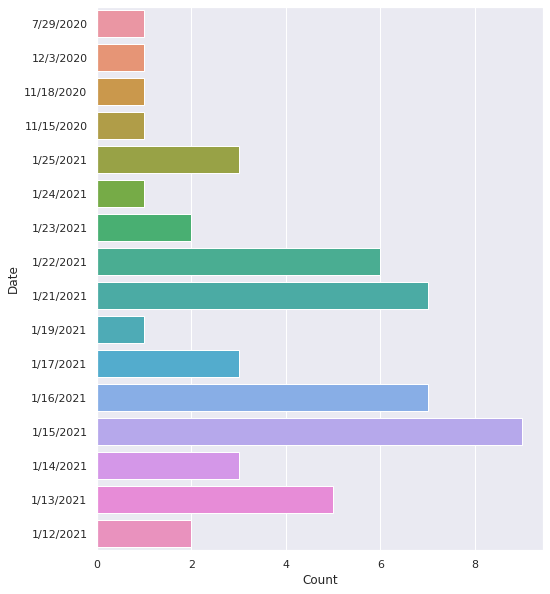

In [ ]:
f, ax = plt.subplots(figsize = (8,10))
sns.set_color_codes('dark')
sns.countplot(y='Date', data=eda_df, orient='h')
ax.set_xlabel('Count')
plt.show()

## Equivalence Classes (EC)

To run EC code, change the ec_code_flag to 1 within the ***Function to process text*** subsection under ***User Functions***

In [ ]:
# only run this if we've done the EC step
# to get the before vs after for the paper, will have to turn it off in the cleaning function and re-run

tmptext = stitch_processed_text[0][0:414]
wordList = res_go()

# Wrap this text. 
wrapper = textwrap.TextWrapper(width=36) 
word_list = wrapper.wrap(text=tmptext)

# Print each line. 
for element in word_list: 
    print(highlight_words(element, wordList))


release national strategy COVID
PANDEMIC include use defense
production power speed manufacturing
test VACCINE supply item need fight
plan release thursday aim instill
confidence PANDEMIC response
accelerate VACCINE boost test access
treatment protect include community
invoke part national strategy defeat
though official official signal
aggressive previous invoke allows
force company increase production
critica


# Vector Representations of Documents

## Term Frequency–Inverse Document Frequency (TF-IDF)

Note the ngram_range will allow you to include multiple words within the TFIDF matrix

A couple things to note about the parameters I define below:

* max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining 
* min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. doron's note: i changed it so that it has to appear in at least 2 documents
* ngram_range: this just means I'll look at unigrams and bigrams.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
#tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
#                                 min_df=2/len(data), use_idf=True, ngram_range=(1,2))

# we ended up using vectoring with just unigrams and default parameters so that the number of terms in our 
# tf-idf matrix matches the entire number of tokens in our full corpus dictionary
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))

#fit the vectorizer to final_processed_text
tfidf_matrix = tfidf_vectorizer.fit_transform(final_processed_text)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index=titles)

print('Done')

Done


In [ ]:
matrix.head()


,aaron,abbreviation,ability,able,abolitionist,abroad,absence,absent,absolute,absorb,abuse,academic,accelerate,access,accomplish,accord,account,accountability,accountable,accrue,accumulation,accurately,accusation,accuse,achieve,achievement,acknowledge,acquaintance,acre,across,act,action,activist,activity,actual,actually,acute,adaptation,add,addition,...,win,wind,winter,wipe,wishful,withdrawn,within,without,withstand,witness,woman,wonder,word,work,worker,workforce,workplace,world,worried,worry,worth,worthwhile,worthy,wound,wrangle,writ,write,wrong,wyner,xavier,xingping,year,yearn,yesterday,york,young,zero,zone,zoom,zuckerberg
File Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Biden-NationalCovidStrategy-Doc1.docx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099229,0.080143,0.0,0.061761,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.06634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.049614,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05452,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Biden_Covid_Strategy (1).txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.020996,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027245,0.0,0.0,0.000000,0.049806,0.0,0.018802,0.025697,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033733,0.0,0.0,0.0,0.0
Biden_Covid_Strategy (2).txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.023200,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.034415,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.030105,0.0,0.0,0.046154,0.000000,0.0,0.020775,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Biden-NationalCovidStrategy-Doc2.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.061621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.035106,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CB_Biden Signs Buy American Order for Government Procurement.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028083,0.0,0.021642,0.046492,0.046492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046492,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.038760,0.026487,0.0,0.0,0.038208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.051337,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


terms is just a list of the features used in the tf-idf matrix. This is a vocabulary

In [ ]:
terms = tfidf_vectorizer.get_feature_names()

dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus. Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### PCA

In [ ]:
# turn our td-idf vectors into 2-dimensional vector using PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents0 = pca.fit_transform(matrix.iloc[:,1:])
principalDf0 = pd.DataFrame(data = principalComponents0
             , columns = ['principal component 1', 'principal component 2'])

dd = {'document': matrix.index,
      'pc1': principalDf0['principal component 1'],
      'pc2': principalDf0['principal component 2']}

tfidf_pca_df = pd.DataFrame(dd)
tfidf_pca_df.head()

,document,pc1,pc2
0,Biden-NationalCovidStrategy-Doc1.docx,0.531281,-0.102846
1,Biden_Covid_Strategy (1).txt,0.560876,-0.038286
2,Biden_Covid_Strategy (2).txt,0.469381,0.036959
3,Biden-NationalCovidStrategy-Doc2.txt,0.535807,-0.072759
4,CB_Biden Signs Buy American Order for Government Procurement.txt,-0.010036,-0.119463


## Doc2Vec


## Word2Vec

In [ ]:
model = Word2Vec(sentences=processed_text, size=64, sg=1, window=10, min_count=5, workers=1)

# sentences - requires a list of lists input
# hyperparameter: 
#   size - number of dimensions that will result from running word2vec
#   sg - setting sg = 1 using the skipgram method (better for small datasets), sg = 0 uses the Cebow method
#   window - the number of words to the left and right of the target word
#   min_count - the minimun number of times a word must occur across the corpus to fit it into a word vector space
#   workers - the number of cpu's on your computer that you would like to use

#### Reduce the 64 word diminsional space down to 2 dimensions

In [ ]:
w2vX = model.wv[model.wv.vocab]

tsne = TSNE(n_components=2, n_iter=1000)

X_2d = tsne.fit_transform(w2vX)

# create a dataframe for storing results and plotting
coords_df = pd.DataFrame(X_2d, columns=['x', 'y'])
coords_df['token'] = model.wv.vocab.keys()
coords_df.head()

,x,y,token
0,10.159036,10.744411,release
1,11.665016,-14.991106,national
2,12.389012,7.003950,strategy
3,13.428693,7.380451,covid
4,14.462220,10.030781,pandemic


#### Visulaize 2D representation of word vectors

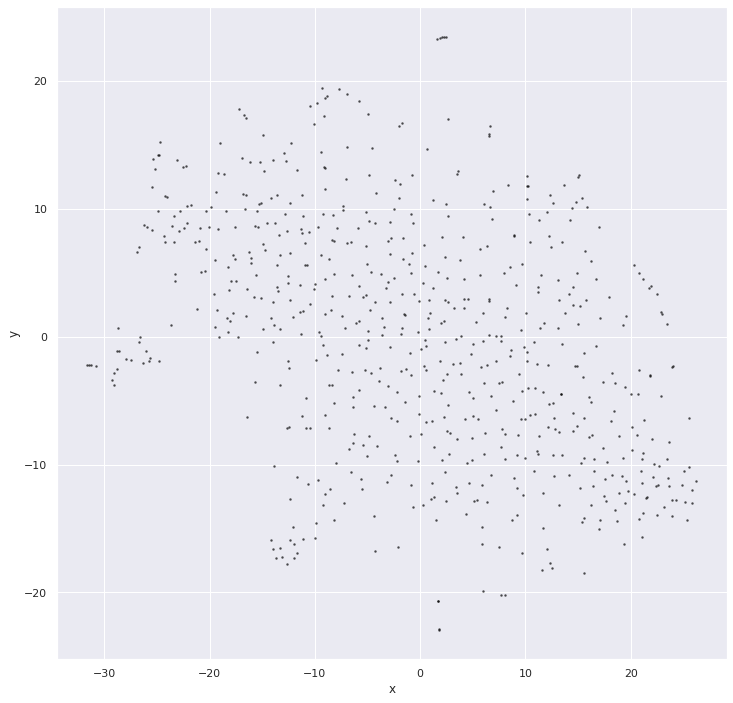

In [ ]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12), marker='.', s=10, alpha=0.5, color='black')

In [ ]:
from bokeh.io import output_notebook
from bokeh.plotting import show, figure

output_notebook()

subset_df = coords_df.sample(n=len(coords_df))

p = figure(plot_width=800, plot_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)

show(p)

## Bag-of-Words

Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_text)
len(dictionary)

3059

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_processed_text)  
word_index = tokenizer.word_index 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print(f'Found {len(word_index)} unique tokens. ')


print(reverse_word_index[1])

#reverse_word_index


Found 3059 unique tokens. 
plan


In [ ]:
# creating the feature matrix 

count_vectorizer = CountVectorizer()
matrix_bow = count_vectorizer.fit_transform(final_processed_text).toarray()
matrix_bow.shape

(53, 3059)

Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_text]
#bow_corpus

Preview BOW for our sample preprocessed document

In [ ]:
document_num = 1
bow_doc_x = bow_corpus[document_num]
#bow_doc_x

#for i in range(len(bow_doc_x)):
#    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
#                                                     dictionary[bow_doc_x[i][0]], 
#                                                     bow_doc_x[i][1]))

In [ ]:
lst_word_num = []
lst_word = []
lst_stem = []
lst_freq = []

for i in range(len(bow_corpus)):
  document_num = i
  bow_doc_x = bow_corpus[document_num]
  for j in range(len(bow_doc_x)):
    lst_word_num.append(bow_doc_x[j][0])
    lst_word.append(dictionary[bow_doc_x[j][0]])
    lst_freq.append(bow_doc_x[j][1])
    
p = {#'word_num': lst_word_num,
     'word': lst_word,
     'freq': lst_freq}

word_stem_df = pd.DataFrame(p)
word_stem_df.sort_values('word').reset_index(drop=True)

,word,freq
0,aaron,1
1,abbreviation,1
2,ability,1
3,ability,1
4,ability,2
...,...,...
8931,zero,2
8932,zero,1
8933,zone,1
8934,zoom,1


In [ ]:
matrix.head()

,aaron,abbreviation,ability,able,abolitionist,abroad,absence,absent,absolute,absorb,abuse,academic,accelerate,access,accomplish,accord,account,accountability,accountable,accrue,accumulation,accurately,accusation,accuse,achieve,achievement,acknowledge,acquaintance,acre,across,act,action,activist,activity,actual,actually,acute,adaptation,add,addition,...,win,wind,winter,wipe,wishful,withdrawn,within,without,withstand,witness,woman,wonder,word,work,worker,workforce,workplace,world,worried,worry,worth,worthwhile,worthy,wound,wrangle,writ,write,wrong,wyner,xavier,xingping,year,yearn,yesterday,york,young,zero,zone,zoom,zuckerberg
File Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Biden-NationalCovidStrategy-Doc1.docx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099229,0.080143,0.0,0.061761,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.06634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.049614,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05452,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Biden_Covid_Strategy (1).txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.020996,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027245,0.0,0.0,0.000000,0.049806,0.0,0.018802,0.025697,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033733,0.0,0.0,0.0,0.0
Biden_Covid_Strategy (2).txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.023200,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.034415,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.030105,0.0,0.0,0.046154,0.000000,0.0,0.020775,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Biden-NationalCovidStrategy-Doc2.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.061621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.035106,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
CB_Biden Signs Buy American Order for Government Procurement.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.028083,0.0,0.021642,0.046492,0.046492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046492,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.038760,0.026487,0.0,0.0,0.038208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.051337,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


# Clustering Algorithms

## Hiarchial clustering (unsupervised)

Next, we chose the Ward clustering algorithm because it offers hierarchical clustering. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. We used the precomputed cosine distance matrix (dist) to calclate a linkage_matrix, which was then plot as a dendrogram.

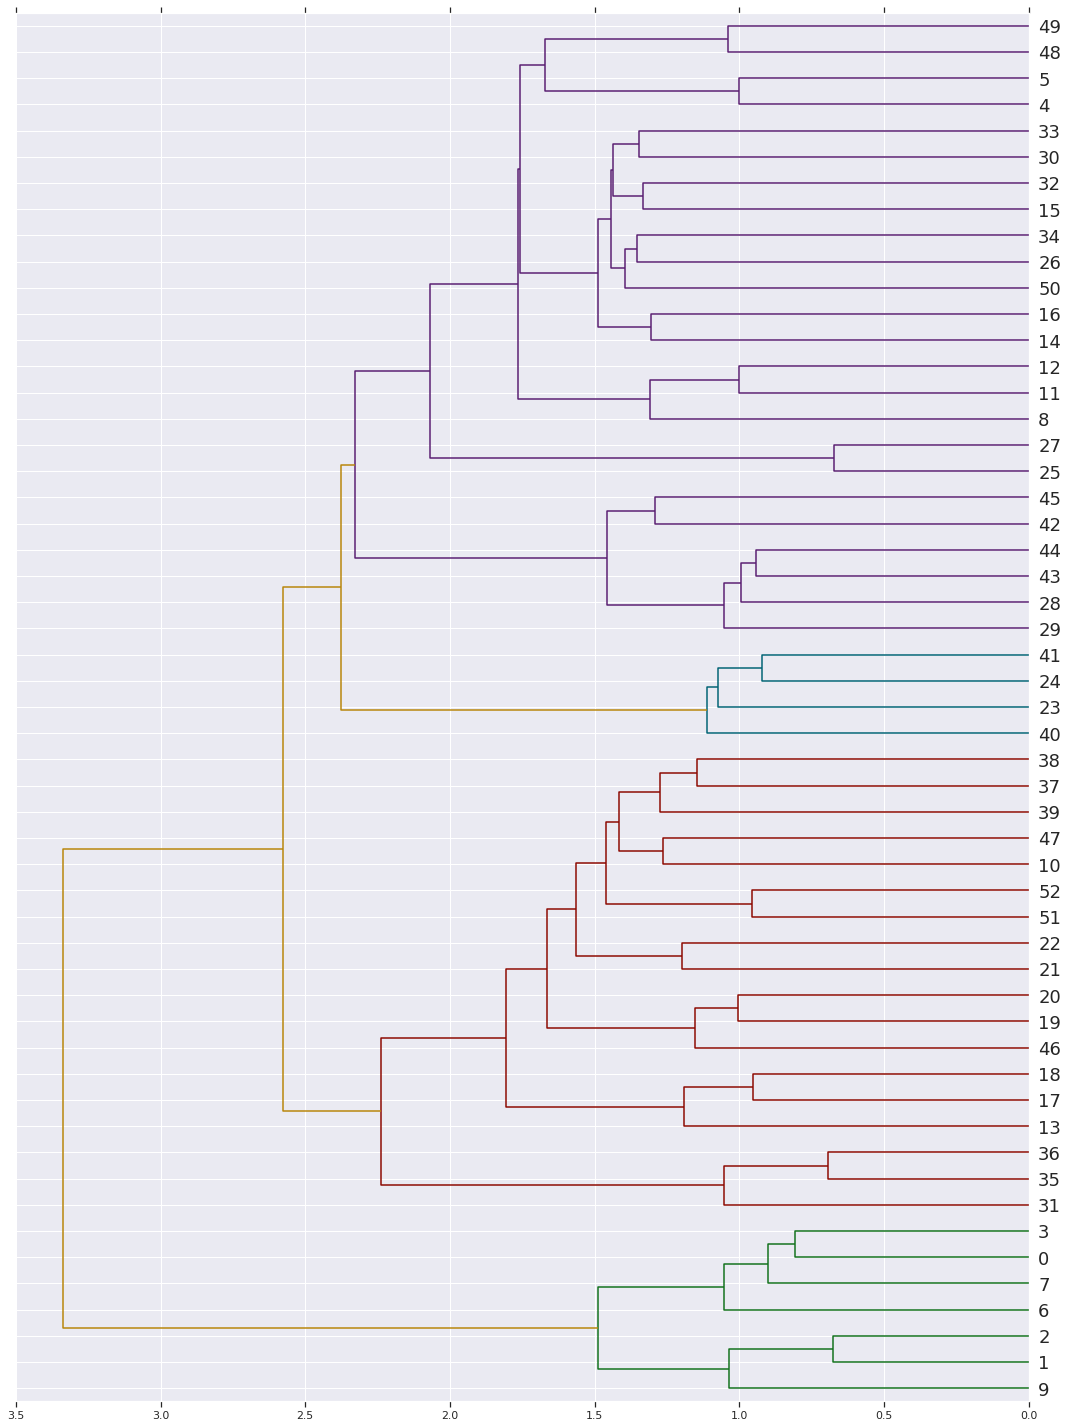

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, above_threshold_color='y',
                orientation='left', leaf_font_size=18)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

## K-means (supervised)

In [ ]:
from sklearn.cluster import KMeans

### Optimum Cluster Methods

#### WSS Scores

We run the cluster analysis using clusters from 1 to 15 to find the Within-Cluster-Sum of Squared (WSS) score.

In [ ]:
WSS = []
K = range(2,15)
for k in K:
    kmopt = KMeans(n_clusters=k)
    kmopt = kmopt.fit(tfidf_matrix)
    WSS.append(kmopt.inertia_*2)

dd = {"Clusters": K,
      "WSS": WSS}

mycenters = pd.DataFrame(dd)

mycenters

,Clusters,WSS
0,2,93.071108
1,3,89.888819
2,4,86.947630
3,5,83.666512
4,6,81.369128
5,7,78.541556
6,8,75.319425
7,9,73.214026
8,10,70.520853
9,11,67.994235


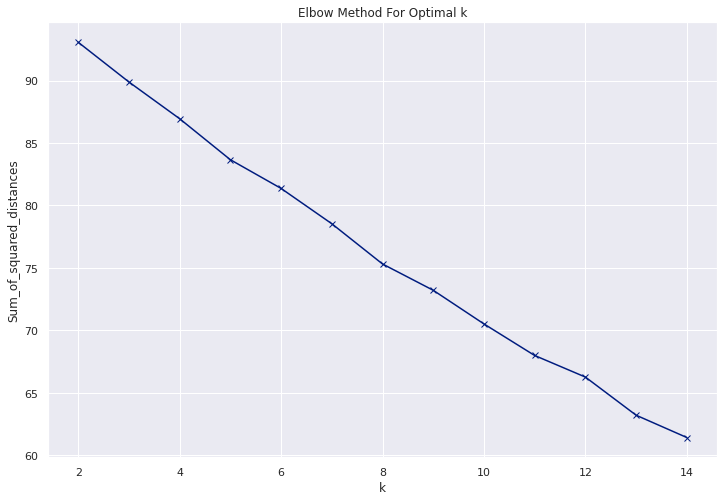

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = plt.plot(K, WSS, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Silhouette Method

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the sub clusters into one big cluster. Adequate clustering occurs when all the plots are more or less of similar thickness and hence are of similar sizes.

For n_clusters = 2 The average silhouette_score is : 0.014512298639822377
For n_clusters = 3 The average silhouette_score is : 0.0177490264691357
For n_clusters = 4 The average silhouette_score is : 0.024929084385592378
For n_clusters = 5 The average silhouette_score is : 0.029666411002022667
For n_clusters = 6 The average silhouette_score is : 0.038096470426638156
For n_clusters = 7 The average silhouette_score is : 0.04376687888238203
For n_clusters = 8 The average silhouette_score is : 0.04438997943512145
For n_clusters = 9 The average silhouette_score is : 0.04672424075251653
For n_clusters = 10 The average silhouette_score is : 0.04530683419695769
For n_clusters = 11 The average silhouette_score is : 0.04953694909615674
For n_clusters = 12 The average silhouette_score is : 0.043675323578866304
For n_clusters = 13 The average silhouette_score is : 0.046353411920246786
For n_clusters = 14 The average silhouette_score is : 0.05346059564181934


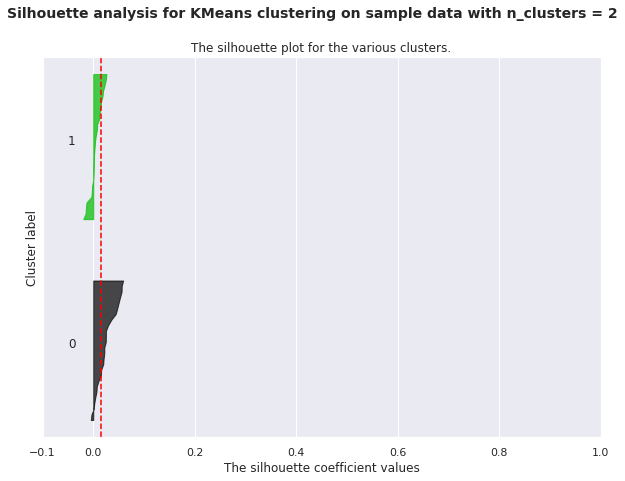

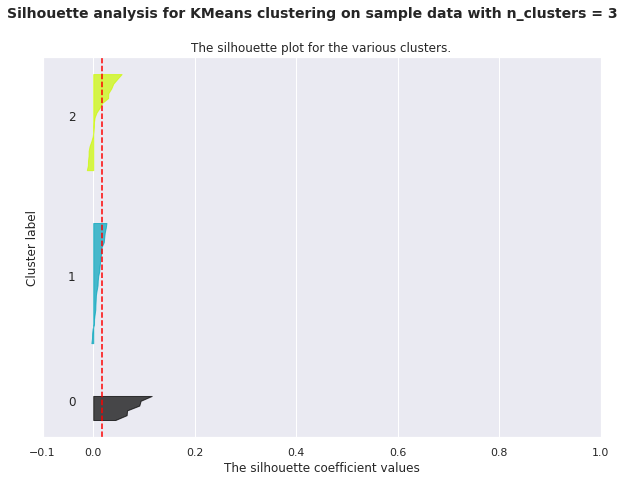

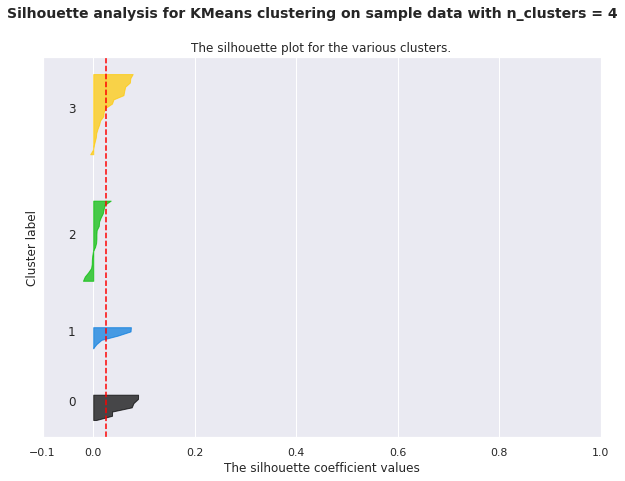

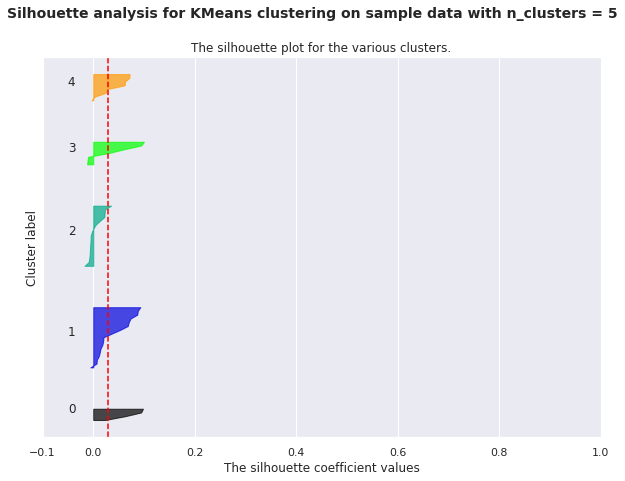

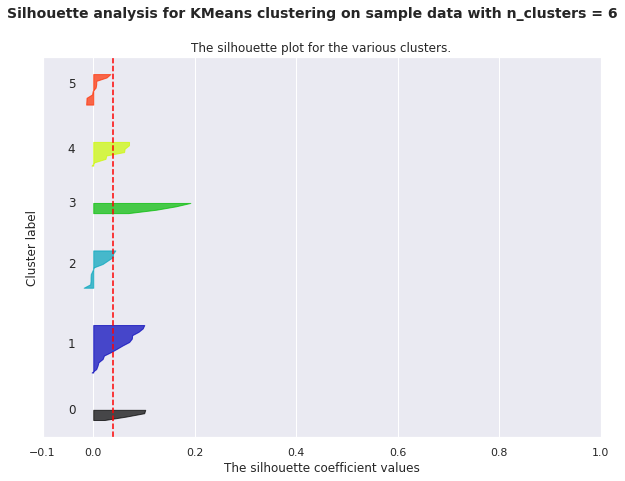

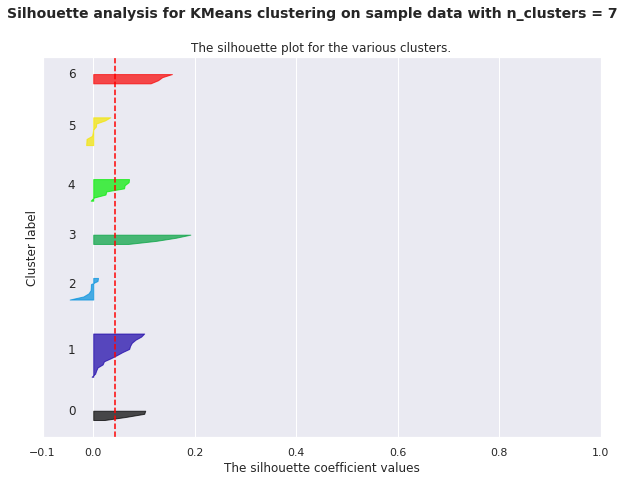

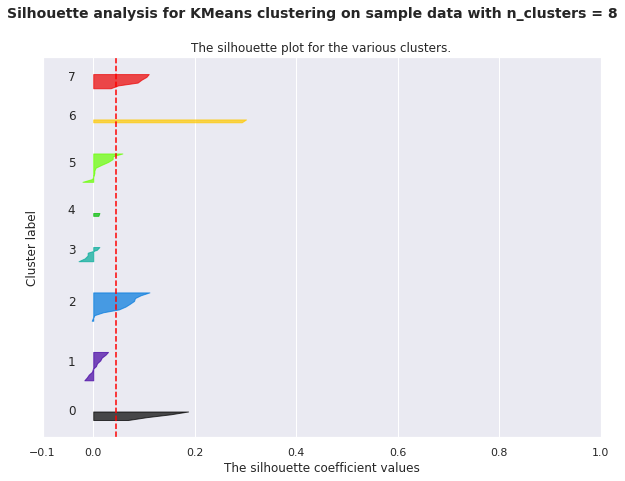

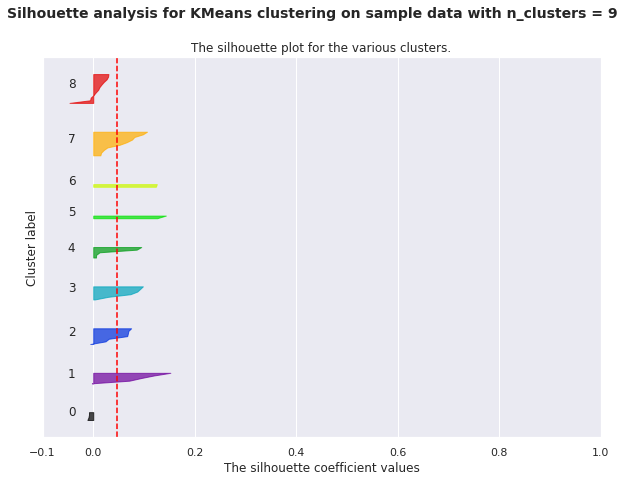

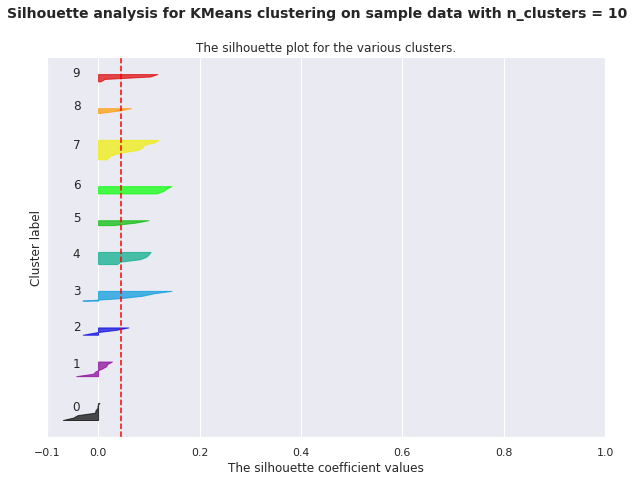

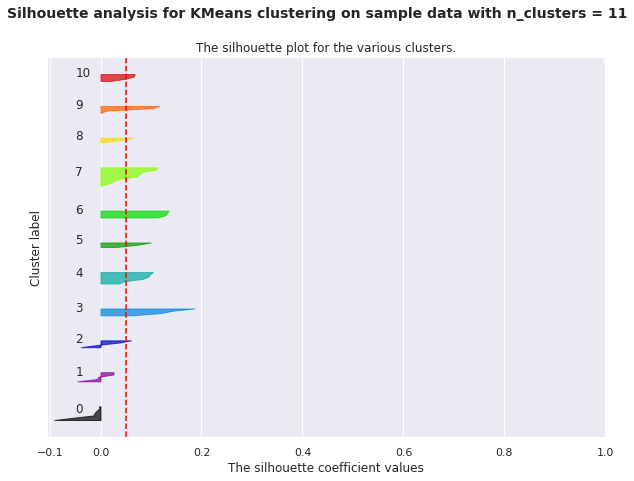

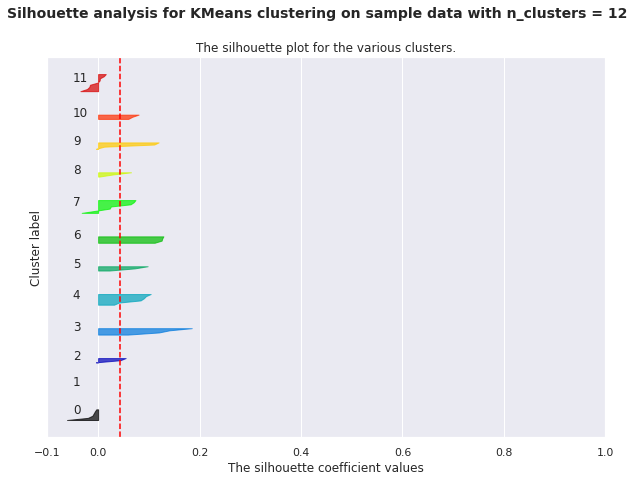

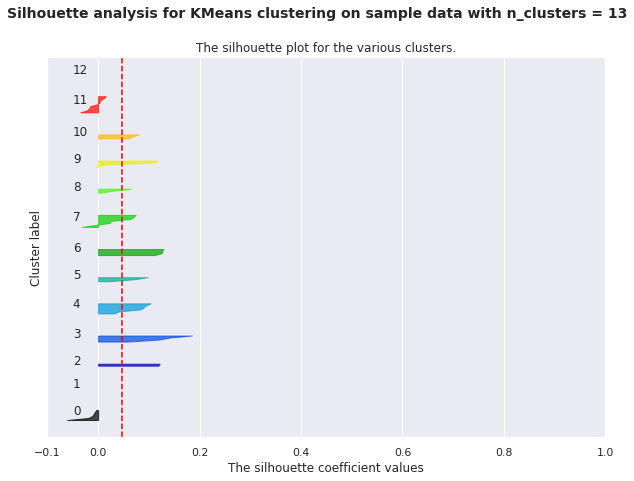

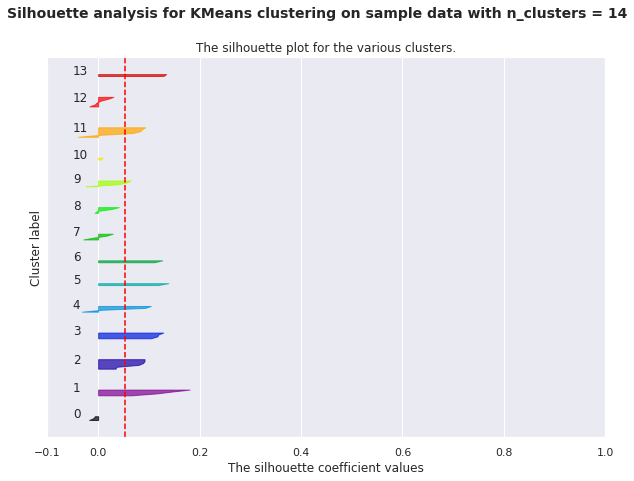

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

X = tfidf_matrix

for n_clusters in K:
  # Create a subplot with 1 row and 2 columns
  fig, ax1 = plt.subplots()
  fig.set_size_inches(10, 7)

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

# Master Number of Clusters

In [ ]:
master_num_clusters = 7

K-means initializes with a pre-determined number of clusters. Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [ ]:
num_clusters = master_num_clusters

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

p = {"cluster": clusters}
cluster_df = pd.DataFrame(p)

grouped = cluster_df['cluster'].value_counts()

print("Top terms per cluster:")

print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #top n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: vaccine, test, supply, order, covid, strategy,

Cluster 1 words: climate, climatechange, kerry, carbon, emission, energy,

Cluster 2 words: credit, child, income, earn, want, refundable,

Cluster 3 words: student, loan, loanforgiveness, borrower, payment, education,

Cluster 4 words: immigration, immigrant, republican, plan, include, border,

Cluster 5 words: healthcare, slavitt, medicare, go, service, telehealth,

Cluster 6 words: vaccine, plan, economy, covid, woman, relief,



## Multidimensional scaling

This code converts the dist matrix into a 2-dimensional array using multidimensional scaling.

In [ ]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

print('Done')

Done


## Visualizing document clusters

define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red', 4: 'purple',
                  5: 'brown', 6: 'pink', 7: 'gray', 8: 'olive', 9: 'cyan'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4', 
                 4: 'Cluster 5',
                 5: 'Cluster 6',
                 6: 'Cluster 7',
                 7: 'Cluster 8',
                 8: 'Cluster 9',
                 9: 'Cluster 10'}

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')
df.head()


,x,y,label,title
0,-0.484429,-0.011696,0,Biden-NationalCovidStrategy-Doc1.docx
1,-0.340906,0.012432,6,Biden_Covid_Strategy (1).txt
2,-0.205903,0.050915,6,Biden_Covid_Strategy (2).txt
3,-0.400152,-0.105310,0,Biden-NationalCovidStrategy-Doc2.txt
4,-0.373546,-0.399693,1,CB_Biden Signs Buy American Order for Government Procurement.txt


In [ ]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

cent_center=[]
for i in range(0,num_clusters):
    cl_tmp = df[df['label']==i]
    cl_tmp = pd.DataFrame({"x": cl_tmp['x'], "y": cl_tmp['y']}).to_numpy()
    cent_center.append(centeroidnp(cl_tmp))
cent_center = pd.DataFrame(data=cent_center, columns=["x", "y"])
cent_center

,x,y
0,-0.499167,0.037427
1,0.108747,-0.552068
2,0.699631,0.070348
3,0.438832,0.503760
4,-0.060094,0.177487
5,-0.107913,-0.293603
6,-0.046059,0.060825


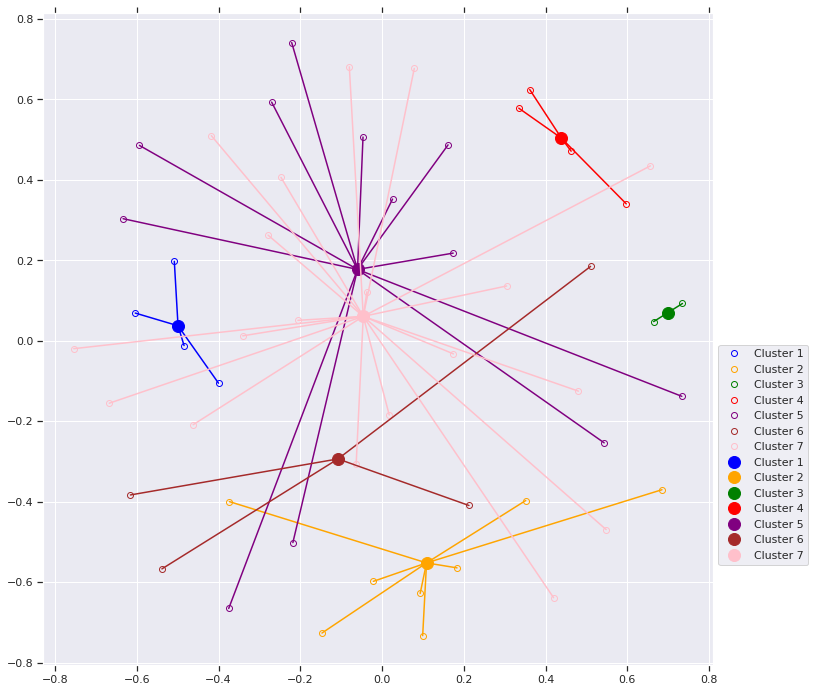

In [ ]:
# set up plot
fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=12, mfc='none',
            label=cluster_names[name], color=cluster_colors[name])
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
for i in range(0,num_clusters):
    ax.plot(cent_center['x'][i], cent_center['y'][i],  marker='o', 
            linestyle='', ms=12, color=cluster_colors[i], label=cluster_names[i])


for j in range(0,num_clusters):
    df_0 = df[df['label']==j]
    df_0 = df_0.reset_index(drop=True)
    for i in range(len(df_0)):
        ax.plot((df_0['x'][i], cent_center['x'][j]), (df_0['y'][i], cent_center['y'][j]), '-', color=cluster_colors[j])



ax.legend(loc='best', bbox_to_anchor=(1, 0.5), numpoints=1)      #show legend with only 1 point

plt.show() #show the plot

# Topic Mapping

## Latent Dirichlet Allocation (LDA)

We are going for 6 topics in the document corpus.

We will be running LDA using all CPU cores to parallelize and speed up model training.

Some of the parameters we will be tweaking are:

* num_topics is the number of requested latent topics to be extracted from the training corpus.
* id2word is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* workers is the number of extra processes to use for parallelization. Uses all available cores by default.
* alpha and eta are hyperparameters that affect sparsity of the document-topic (theta) and topic-word (lambda) distributions. We will let these be the default values for now(default value is 1/num_topics)
  * Alpha is the per document topic distribution.
    * High alpha: Every document has a mixture of all topics(documents appear similar to each other).
    * Low alpha: Every document has a mixture of very few topics
  * Eta is the per topic word distribution.
     * High eta: Each topic has a mixture of most words(topics appear similar to each other).
     * Low eta: Each topic has a mixture of few words.
* passes is the number of training passes through the corpus

In [ ]:
lda_model = gensim.models.LdaModel(corpus = bow_corpus, 
                                   num_topics = master_num_clusters, 
                                   id2word = dictionary,                                    
                                   random_state=826,
                                   update_every=1,
                                   chunksize=10,
                                   passes=10,
                                   alpha='symmetric',
                                   iterations=100,
                                   per_word_topics=True)

For each topic, we will explore the words occuring in that topic and its relative weight

In [ ]:
#for idx, topic in lda_model.print_topics(-1):
#    print("Topic: {} \nWords: {}".format(idx, topic ))
#    print("\n")

How do we interpret this?

Topic 0 is a represented as 0.029*"credit" + 0.015*"income" + 0.012*"premium" + 0.010*"age" + 0.008*"gap" + 0.007*"rate" + 0.007*"level" + 0.006*"mostly" + 0.006*"extra" + 0.005*"healthcare"

This means the top 10 keywords that contribute to this topic are: credit, income, premium, age, gap, rate, level, mostly, extra, and healthcare

### Compute Model Coherence Score

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts.

Coherence Measures include:
* C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
* C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
* C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
* C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
* C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
* C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_text, dictionary=dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3383973171335501


### LDA Hyperparameter Tuning

Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:
* Number of Topics (K)

We’ll use C_v as our choice of metric for performance comparison

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaModel(corpus = bow_corpus, 
                                   num_topics = k, 
                                   id2word = dictionary,                                    
                                   random_state=100,
                                   update_every=1,
                                   chunksize=10,
                                   passes=10,
                                   alpha='auto',
                                   iterations=1000,
                                   per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_text, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 21
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Coherence': []}
 
# iterate through number of topics
#for k in topics_range:
#    # iterate through alpha values
#    try:
#      cv = compute_coherence_values(corpus=bow_corpus, 
#                                    dictionary=dictionary, 
#                                    k=k)
#      # Save the model results
#      model_results['Topics'].append(k)
#      model_results['Coherence'].append(cv)
#    except:
#      pass
#    print('Complete kth cycle', k)
#
#hyperP = pd.DataFrame(model_results)

In [ ]:
#figure
#fig, ax1 = plt.subplots()
#fig.set_size_inches(13, 10)

#labels
#ax1.set_xlabel('Number of Clusters', fontsize=14)
#ax1.set_ylabel('C_v Score')
#ax1.set_title('Model 4 - Topic Coherence: Determining optimal number of topics', fontsize=16)
#plt.xticks(np.arange(0, 22, step=1))
#plt.plot(hyperP['Topics'], hyperP['Coherence'], "b--", label="Coherence")
#ax1.grid(True)
#
#plt.show()

In [ ]:
#hyperP.sort_values(by='Coherence', ascending=False)

### What is the probability distribution of topics for each document?

In [ ]:
prob_dist_temp = [lda_model.get_document_topics(doc) for doc in bow_corpus]

doc_tmp = []
top_tmp = []
prob_tmp = []

for i in range(len(prob_dist_temp)):
    tmp_ = prob_dist_temp[i]
    for j in range(len(tmp_)):
        doc_tmp.append(i)
        top_tmp.append(tmp_[j][0] + 1)
        prob_tmp.append(tmp_[j][1])
        
dd = {'doc_tmp': doc_tmp,
     'top_tmp': top_tmp,
     'prob_tmp': prob_tmp}

crap = pd.DataFrame(dd)
topic_dist = crap.pivot(index="doc_tmp", columns="top_tmp", values="prob_tmp").fillna(0)
topic_dist = pd.DataFrame(topic_dist.to_records())
topic_dist = topic_dist.drop(columns = ['doc_tmp'])
#topic_dist



[Text(66.5, 0.5, 'Documents'), Text(0.5, 156.5, 'Topics')]

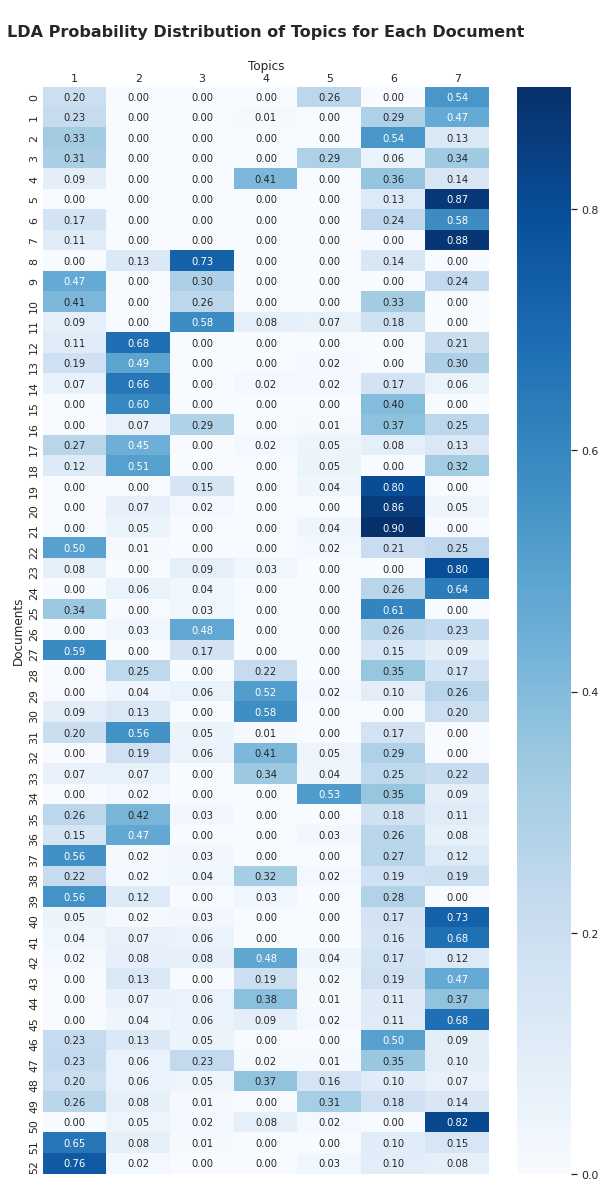

In [ ]:
# visualize probability distribution

fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(topic_dist, cmap="Blues", annot=True, fmt=".2f")

ax.set_title("\nLDA Probability Distribution of Topics for Each Document\n", fontsize=16, fontweight="bold")
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.tick_params(axis='both', which='both', length=0)
ax.set(xlabel='Topics', ylabel='Documents')


In [ ]:
from google.colab import files
files.download("example.html") 

### What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, 
                                                  corpus=bow_corpus, 
                                                  texts=final_processed_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'] + 1
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.5443,"household, include, state, immigration, national, order, risk, office, power, access",release national strategy covid pandemic include use defense production power speed manufacturin...
1,1,7.0,0.4659,"household, include, state, immigration, national, order, risk, office, power, access",pledge friday boost supply covid vaccine vaccine site meet goal million shot part broader covid ...
2,2,6.0,0.5445,"receive, republican, people, allow, go, step, work, across, back, time",unveiled trillion covid plan thursday crisis deep human speed vaccine pump financial help strugg...
3,3,7.0,0.3381,"household, include, state, immigration, national, order, risk, office, power, access",expert expect united covid death toll reach half million people next strategy covid response pan...
4,4,4.0,0.4087,"climate, energy, emission, carbon, climatechange, position, secretary, warm, clean, large",sign executive order monday impose tougher rule procurement practice increase purchase product m...


### The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet['Topic_Num'] = sent_topics_sorteddf_mallet['Topic_Num'] + 1

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1.0,0.7566,"relief, worker, million, economy, american, help, covid, benefit, food, work",covid pandemic force united state economy economy across million american million renter behind ...
1,2.0,0.6803,"action, student, loan, offer, pass, interest, right, payment, borrower, executive",make payment cut private payer administer medicare advantage plan option decides opposite percep...
2,3.0,0.7270,"premium, subsidy, vote, change, record, expect, path, pass, since, healthcare",last georgia runoff election give democrat seat party control house fitch rating outcome provide...
3,4.0,0.5754,"climate, energy, emission, carbon, climatechange, position, secretary, warm, clean, large",resume effort redesign bill feature abolitionist harriet press secretary psaki important money r...
4,5.0,0.5279,"access, career, effective, woman, protect, employer, navigate, scientist, future, racial",heighten security concern derail plan beloved amtrak trip wilmington january commuter rail playe...
5,6.0,0.9018,"receive, republican, people, allow, go, step, work, across, back, time",numerous investment improve quality education community college well hbcus minority institution ...
6,7.0,0.8839,"household, include, state, immigration, national, order, risk, office, power, access",first full office issue sweep executive order tackle rag covid pandemic rapidly reverse refashio...


### Word Clouds of Top N Keywords in Each Topic

Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

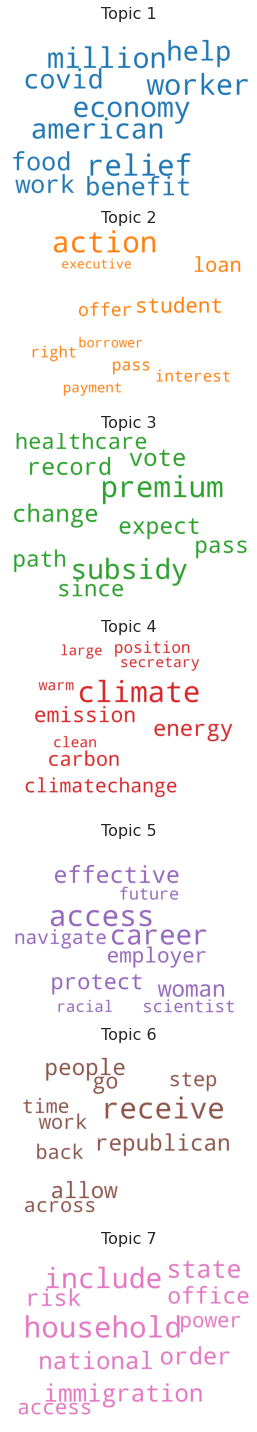

In [ ]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'



cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=18,
                  #collocations=False,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(math.ceil(master_num_clusters), 1, figsize=(10, 20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
    plt.gca().axis('off') 

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


### Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

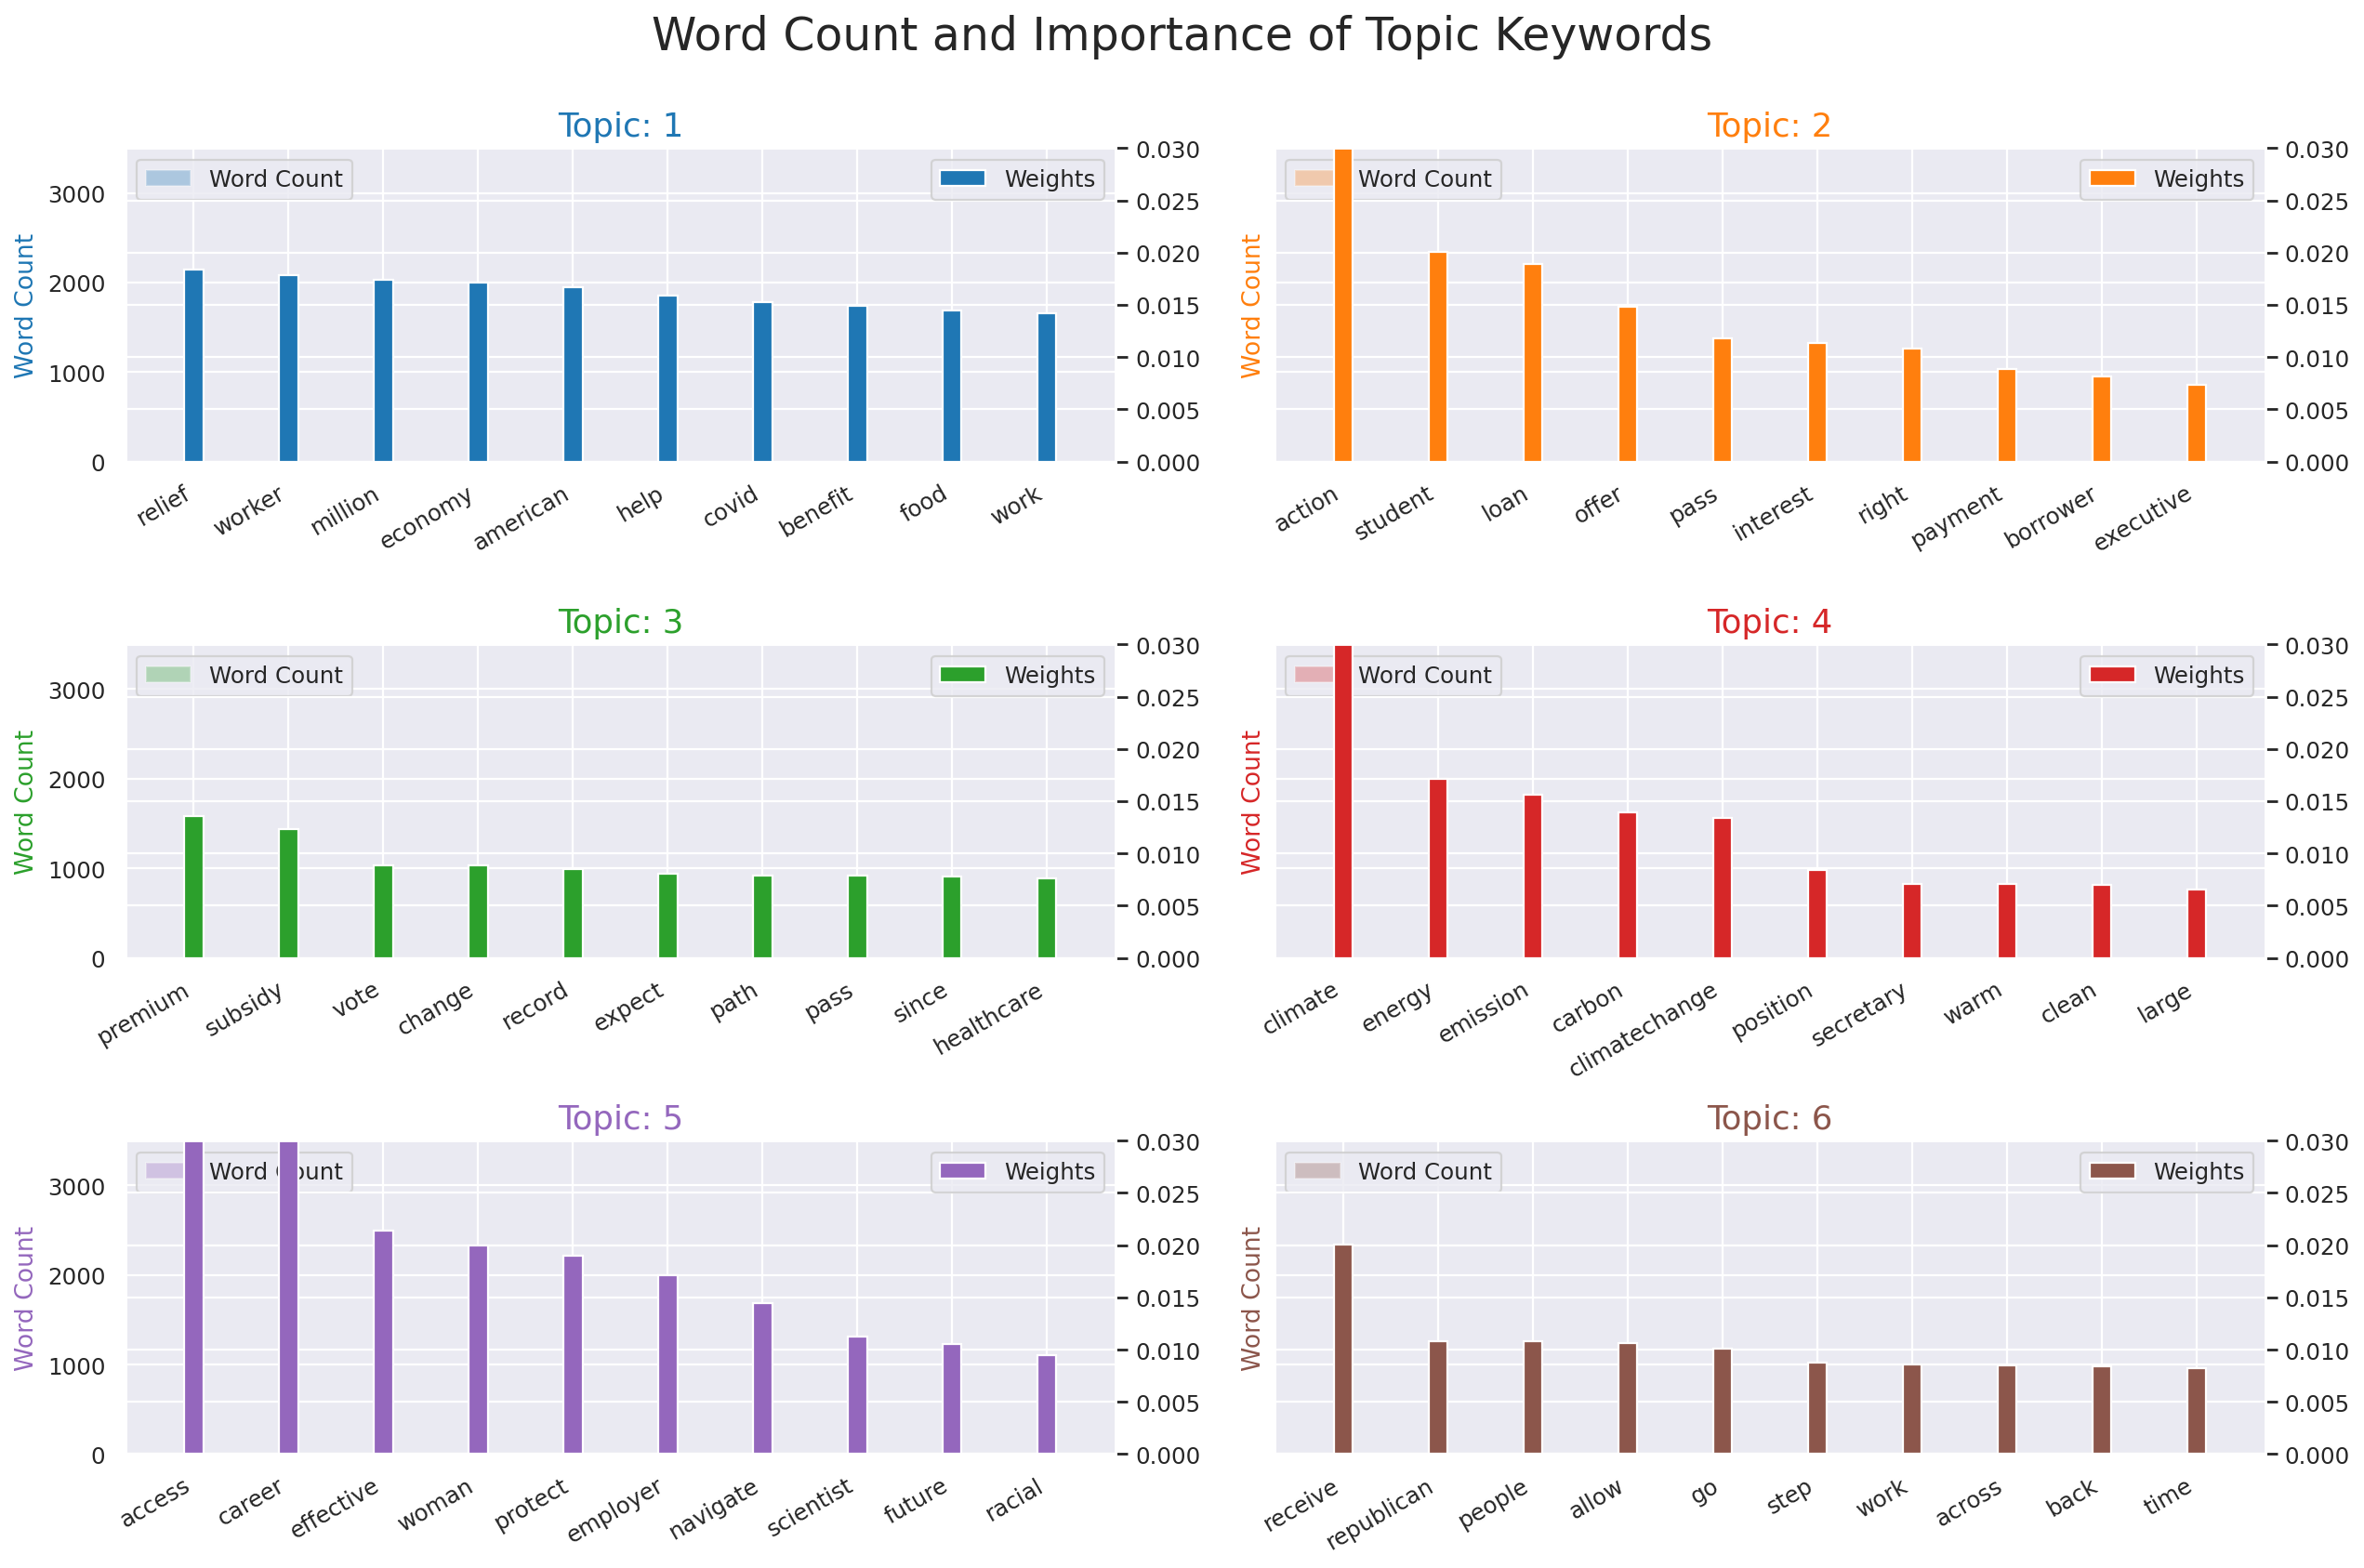

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in final_processed_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])      

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(int(master_num_clusters/2), 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i + 1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

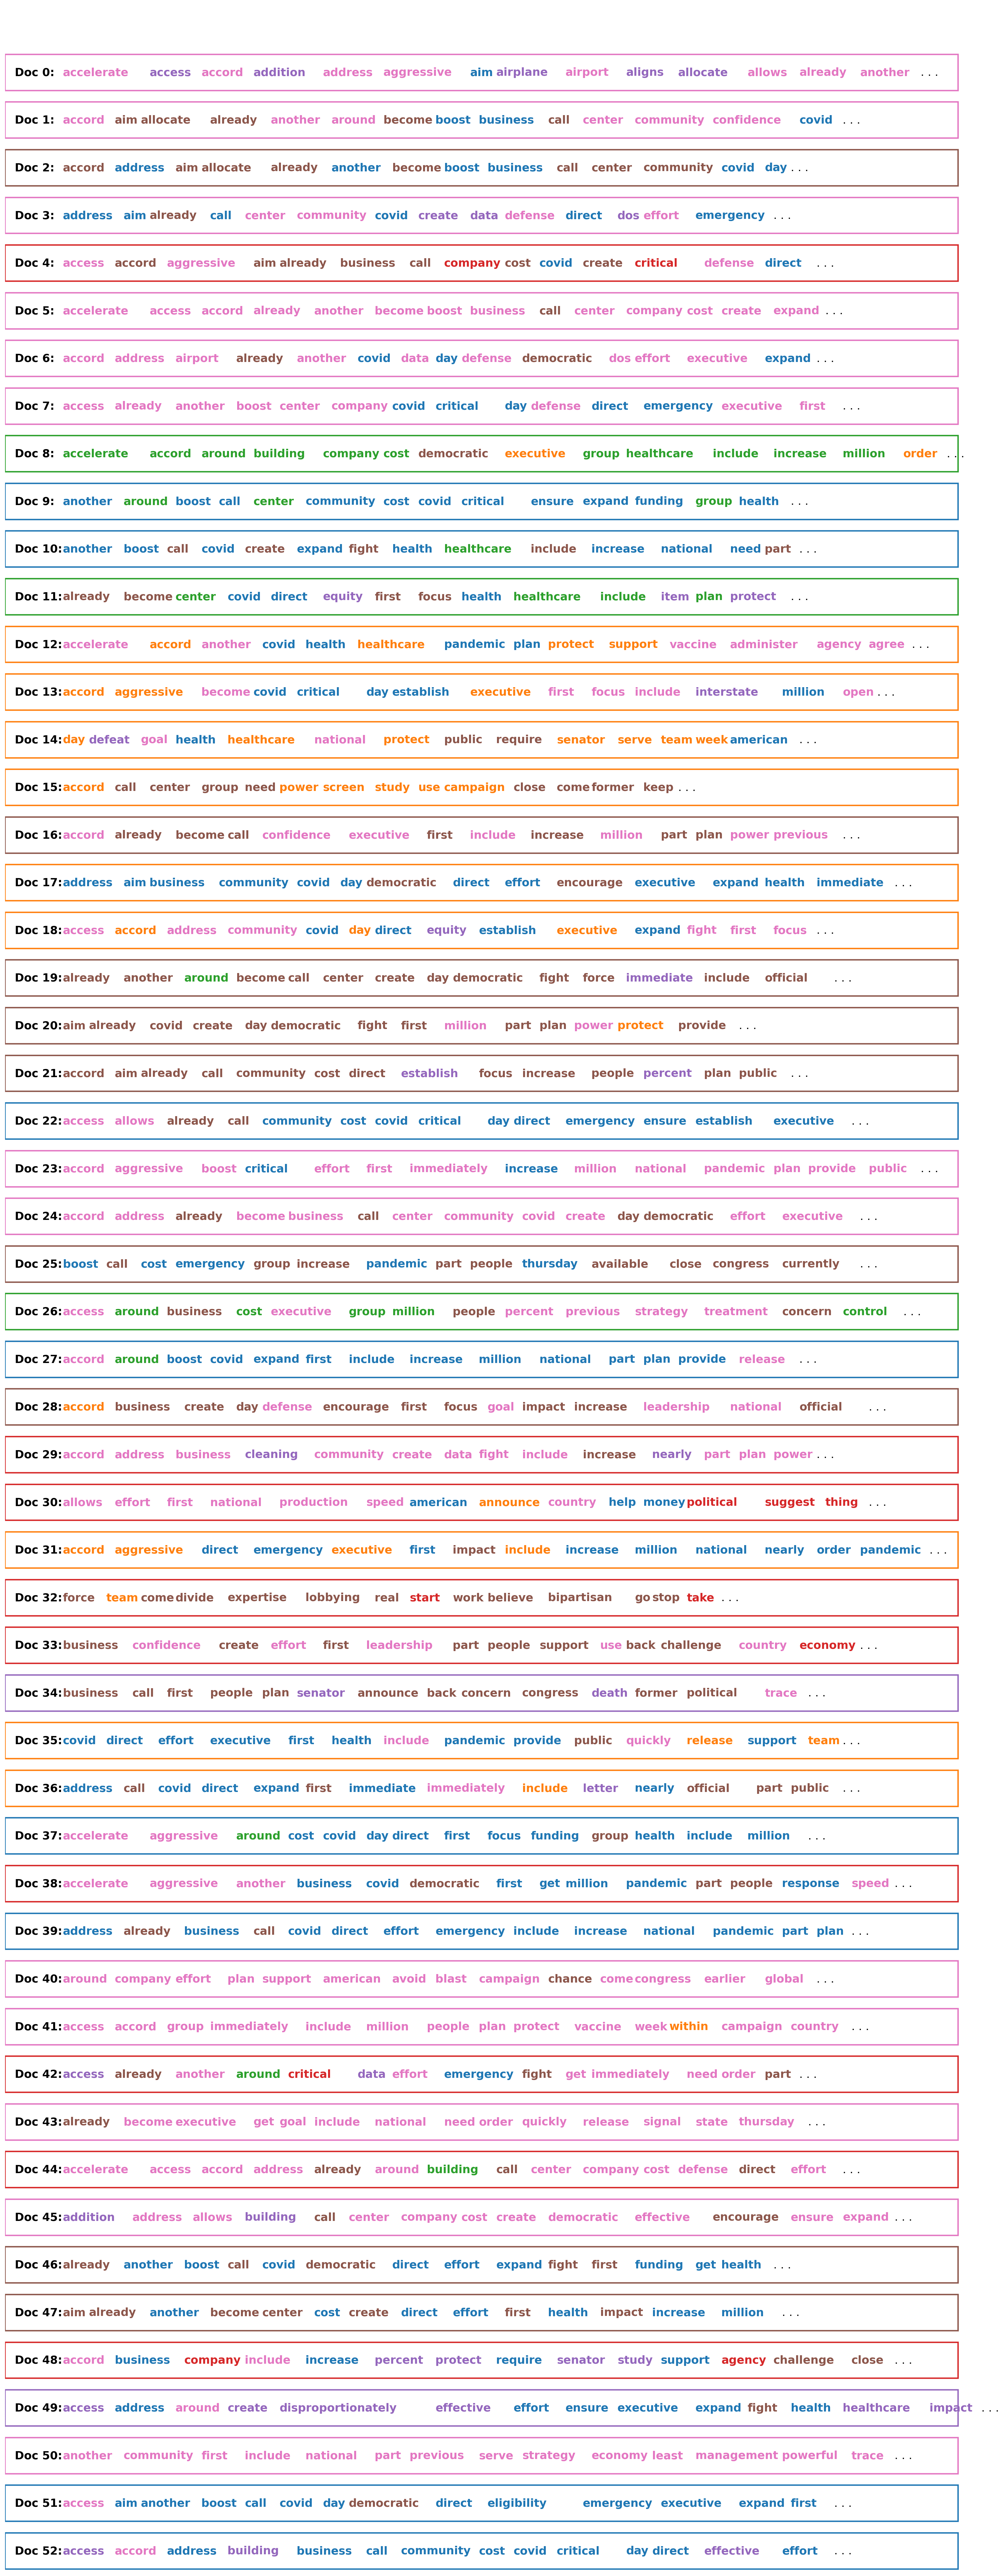

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=bow_corpus, start = 0, end = len(bow_corpus)+1):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

sentences_chart() 

### What are the most discussed topics in the documents?

Let’s compute the total number of documents attributed to each topic.

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bow_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
df_dominant_topic_in_each_doc['Dominant_Topic'] = df_dominant_topic_in_each_doc['Dominant_Topic'] + 1

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()
df_topic_weightage_by_doc['index'] = df_topic_weightage_by_doc['index'] + 1

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words['topic_id'] = df_top3words['topic_id'] + 1



Let’s make two plots:
* The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
* The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
#fig, (ax1) = plt.subplots( figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
#ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
#ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
#tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
#ax1.xaxis.set_major_formatter(tick_formatter)
#ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
#ax1.set_ylabel('Number of Documents')
#ax1.set_ylim(0, 12)

#plt.show()

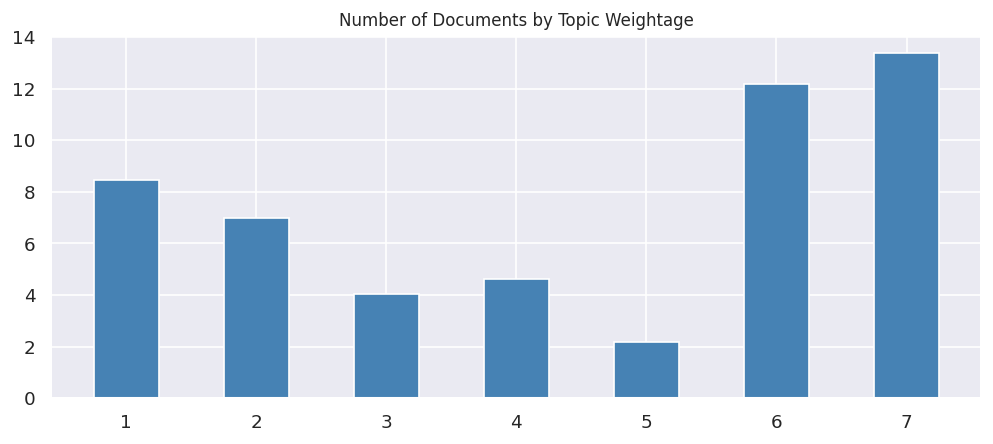

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax2) = plt.subplots( figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
#ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
#ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### Latent Semantic Analysis (LSA)

Having obtained our tf-idf matrix - a sparse matrix object, we now apply the TruncatedSVD method to first reduce the dimensionality of the Tf-idf matrix to a decomposed feature space using LSA (Latent Semantic Analysis) method.

LSA has been one of the classical methods in text that have existed for a while allowing "concept" searching of words whereby words which are semantically similar to each other (i.e. have more context) are closer to each other in this space and vice-versa.

In [ ]:
# Applying the Singular value decomposition
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3, random_state=2018)
svd_tfidf = svd.fit_transform(tfidf_matrix)
print("Dimensionality of LSA space: {}".format(svd_tfidf.shape))

Dimensionality of LSA space: (53, 3)


In [ ]:
svd_tfidf = pd.DataFrame(svd_tfidf, columns = ['x','y','z'])
svd_tfidf['Topic'] = df_dominant_topic['Dominant_Topic'].astype(str)
svd_tfidf.head()

,x,y,z,Topic
0,0.529625,0.429422,-0.119336,7.0
1,0.525499,0.467685,-0.051125,7.0
2,0.601816,0.313046,0.037584,6.0
3,0.490118,0.462699,-0.092459,7.0
4,0.325524,-0.061283,-0.112690,4.0


Quickly plotting a scatter plot of the first 3 dimensions of the latent semantic space just to get an initial feel for how the target variables are distributed:

In [ ]:
import plotly.express as px
fig = px.scatter_3d(svd_tfidf, x='x', y='y', z='z', color='Topic',
                    color_discrete_map={
                        "1.0": "red",
                        "2.0": "green",
                        "3.0": "blue",
                        "4.0": "goldenrod", # dark orange
                        "5.0": "magenta",
                        "6.0": "#750D86", # purple
                        "7.0": "#222A2A", # black
                        "8.0": "#C9FBE5", # cyan
                        "9.0": "#1616A7", # Navy
                        "0.0": "#AF0038" }) # Maroon
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()